In [3]:
import numpy as np

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
import matplotlib.pyplot as plt

# Weekly Project incorporating Transfer Learning

In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

## Transfer Learning for Neural Networks

> Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis (japanese racoons).

__The benefits of transfer learning are:__
* you can reuse pre-trained networks
* it saves lots of training time
* it allows you to train with very small training datasets

__Procedure__
1. Take the weights and architecture of a [pre-trained network](https://keras.io/api/applications/)
2. Load the "convolutional base" of the model (everything except the final dense layers)
3. Freeze all the layers of the base (weights become fixed)
4. Add a fully connected dense layer on top
5. **Add a task specific dense output layer**
6. Compile and fit the model to your data

## Load images into `keras`
Keras has its own in build Objects and Methods to get image data in efficiently
See: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image

- `class ImageDataGenerator`: Generate batches of tensor image data with **optional** real-time data augmentation

In [27]:
# folder names containing images of the things you want to classify
classes = ['garlic','lemon','mask']
# plug in the path to your data folder
base_path = '/Users/sebastian/Documents/spiced_projects/euclidean_eukalyptus/work/09_week/weekly_project/data'

In [20]:
# !unzip data

In [28]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
     #rotation_range=45,
     #width_shift_range=0.2,
     #height_shift_range=0.2,
     #horizontal_flip=True, 
     #vertical_flip=True,
    #zoom_range=0.2,
    shear_range=0.2    
)

In [29]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=30,
        target_size=(224, 224)
)

Found 2149 images belonging to 3 classes.


In [31]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((30, 224, 224, 3), (30, 3))

In [32]:
def plotImages(images_arr):
    fig, axes = plt.subplots(6, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

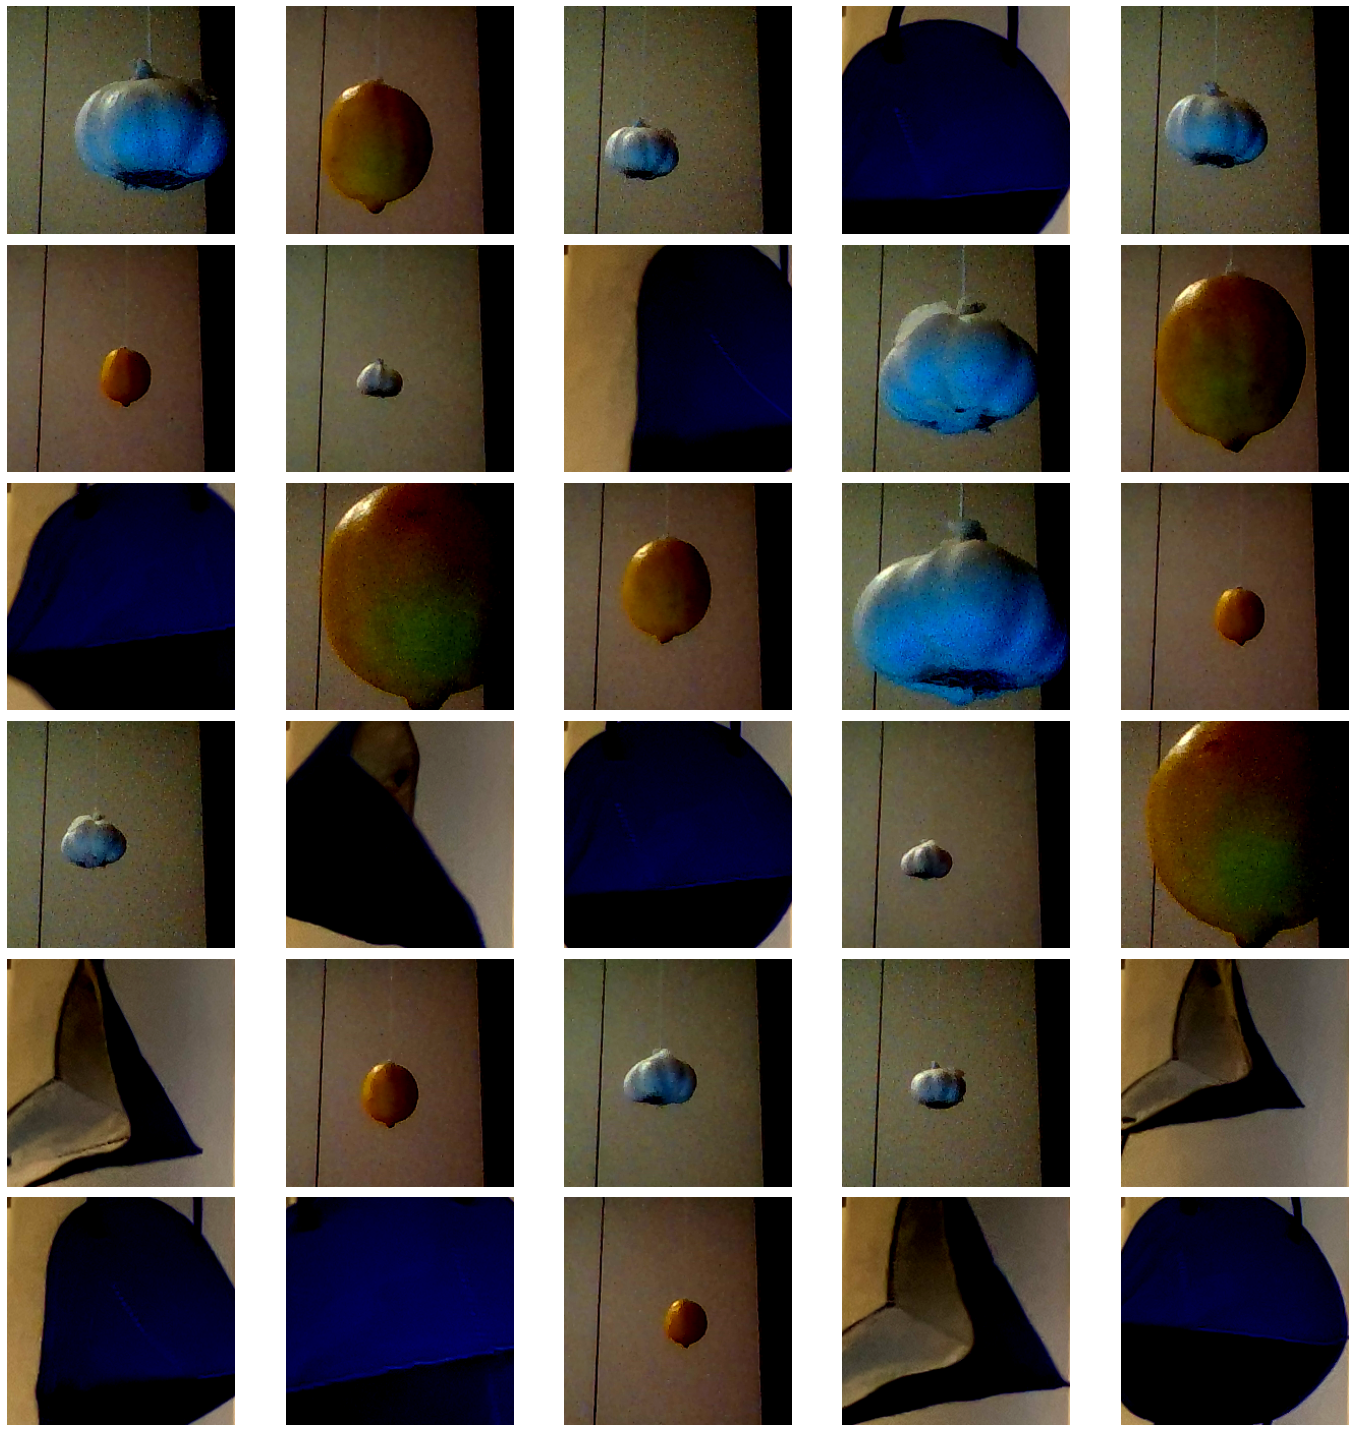

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [33]:
plotImages(xtrain)
print(ytrain)

In [34]:
classes

['garlic', 'lemon', 'mask']

In [35]:
ytrain

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## Create CNN Model

### 1. Select the convolutional base 

In [38]:
base_model = VGG16(
    weights='imagenet', 
    #alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

58892288/58889256 [==============================] - 15s 0us/step


Alpha parameter : Controls the width of the network. This is known as the width multiplier in the MobileNet paper. - If alpha < 1.0, proportionally decreases the number of filters in each layer. - If alpha > 1.0, proportionally increases the number of filters in each layer. - If alpha = 1, default number of filters from the paper are used at each layer. Default to 1.0.


### 2. Freeze the weights

In [39]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [40]:
# freeze it!
base_model.trainable = False

### 3. Add your own dense layers on top

In [41]:
len(classes)

3

In [42]:
model = keras.Sequential()
model.add(base_model)

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 14,766,291
Trainable params: 51,603
Non-trainable params: 14,714,688
_________________________________________________________________


### 4. Compile and train!

In [43]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.3)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow t

### (5. Use it to predict)

In [117]:
test_img = image.load_img('/Users/sebastian/Documents/spiced_projects/euclidean_eukalyptus/work/09_week/weekly_project/test_01/test_03.png')

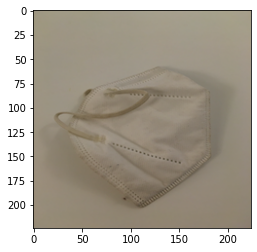

In [118]:
plt.imshow(test_img)

In [119]:
test_img.size

(224, 224)

In [ ]:
#pip install scikit-image

In [72]:
from skimage.transform import resize

In [ ]:
#a = resize(img, (224,224))

In [120]:
a = image.img_to_array(test_img)

In [116]:
#a

Type:        ndarray
String form:
[[[203. 199. 185.]
           [203. 198. 186.]
           [205. 199. 187.]
           ...
           [206. 202. 189.]
           [208. 202. 18 <...> 6. 185. 164.]
           [197. 186. 168.]
           ...
           [178. 165. 154.]
           [180. 166. 153.]
           [179. 167. 149.]]]
Length:      224
File:        /opt/homebrew/Caskroom/miniforge/base/envs/tf_m1_project/lib/python3.8/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a lo

In [121]:
a = np.expand_dims(a, axis = 0)

In [122]:
a.shape

(1, 224, 224, 3)

In [105]:
model.predict(a)

array([[1.0478729e-19, 3.7291938e-16, 1.0000000e+00]], dtype=float32)

In [106]:
model.predict(a)[0].round(decimals = 3)

array([0., 0., 1.], dtype=float32)

In [107]:
classes

['garlic', 'lemon', 'mask']

<BarContainer object of 3 artists>

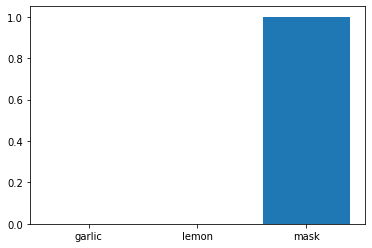

In [108]:
plt.bar(x = classes, height = model.predict(a)[0])

### (6. Save your model for later)

In [55]:
model.save('models/garlic_lemon_mask.h5')

---
### Advanced Optional Step: Fine Tuning

This is done after the initial training! Adapt a few of the base layers to the specific learning task by retraining the model. This can improve accuracy, especially if the original learning task of the pre-trained model differs a lot from the actual task.

1. Unfreeze some (or all) of the layers in the convolutional base (starting with the base output layer)
2. Recompile your model and choose a very low learning rate (`1e-5`)
2. Continue training the model but stop early to avoid overfitting

#### (Advanced: Data augmentation)

> https://keras.io/guides/transfer_learning/

> https://www.tensorflow.org/tutorials/images/data_augmentation

Applies random distortions and transformations to the images (only on your training data!). You need to store your training and validation data at separate locations and use a second `ImageDataGenerator` for your validation data. 

---
---

## Our project: How to continue!

1. Have image data in the categories we want to classify: check
2. Have a model to use:
    - One or several pre-trained models
    - Train your own with transfer learning <-- will probably have the best performance
    - Take the challenge and train your own from scratch
4. Test on your data, evaluate, reflect

5. Save the model(s)

6. Load the trained model into `predict.py` (the modified `capture.py` with the `predict_frame(frame)` function) 


- If you don't have it yet, write a fuction `predict_frame(frame)` that uses the trained model to predict the object in the current frame. It should return a dictionary of class probabilities and names.
    - make sure that the input image to the model is of size (224, 224)
- Modify the script such that it makes a prediction once you press the `p` key
- Write the prediction as a log message to the terminal

### Advanced

- Display the result of the prediction on the current webcam frame
- Make an automatic prediction every second (Hint: the `while` loop has a speed of approx. 30 frames per second)

In [128]:
# Let's explore the data folder
base_path = '/Users/sebastian/Documents/spiced_projects/euclidean_eukalyptus/work/09_week/weekly_project/data/'

# Let's define the classes
classes = os.listdir(base_path)

In [134]:
for class_ in classes:
        print(class_)
        #class_name = os.path.join(base_path, class_)
        #if os.path.isfile(class_name):
                #print(class_)

.DS_Store
lemon
mask
garlic


In [126]:
def load_image(base_path):
    """it loads all the image into X and the classes in y """
    X_list = []
    y_list = []
    classes = os.listdir(base_path)
    ext = ('.png','.jpeg')
    for class_ in classes:
        
        files = os.listdir(base_path+class_)
        #print(files)
        for file in files:
            if files.base_path.endswith(ext):
                pic = keras.preprocessing.image.load_img(path=base_path+class_+'/'+f'{file}',target_size=(224,224))
                numpy_image = np.array(pic)
                processed_image = preprocess_input(numpy_image)
                X_list.append(processed_image)
                y_list.append(class_)
        
    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y, classes

In [127]:
X,y,classes= load_image(base_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sebastian/Documents/spiced_projects/euclidean_eukalyptus/work/09_week/weekly_project/data.DS_Store'

In [108]:
X.shape

(150, 224, 224, 3)

In [109]:
y

array(['wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'wallet', 'wallet', 'wallet',
       'wallet', 'wallet', 'wallet', 'phone', 'phone', 'phone', 'phone',
       'phone', 'phone', 'phone', 'phone', 'phone', 'phone', 'phone',
       'phone', 'phone', 'phone', 'phone', 'phone', 'phone', 'phone',
       'phone', 'phone', 'phone', 'phone', 'phone'

In [110]:
my_dict = {"wallet":0, "phone":1}

In [111]:
y = np.vectorize(my_dict.get)(y)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])